In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

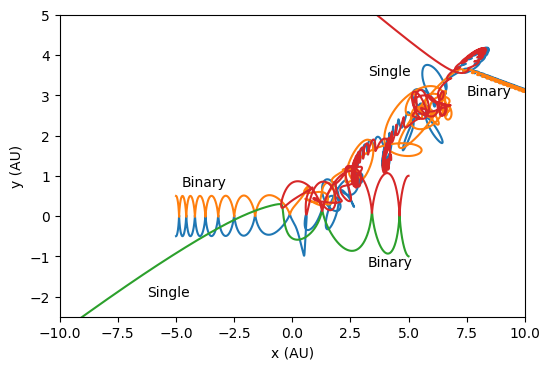

Done


In [42]:
##############################################################################
# INITIAL CONDITIONS
#
def initialize_problem():
    # The initial conditions
    R1 = np.array([-5.0,-0.5,0.0])
    #R1 = np.array([0.87635,-0.45262,0.0])
    V1 = np.array([0.15,0.0,-0.19])
    R2 = np.array([-5.0,0.5,0.0])
    V2 = np.array([0.15,0.0,0.20])
    R3 = np.array([5.0,-1.0,0.0])
    V3 = np.array([-0.15,0.03,-0.11])
    R4 = np.array([5.0,1.0,0.0])
    V4 = np.array([-0.15,0.0,0.10])

    # Store in state vector
    x = np.concatenate((R1,V1,R2,V2,R3,V3,R4,V4))
    
    # Mass of the bodies
    masses = [1.0,1.0,1.0,1.0]
    
    # Gravitational parameter 
    G  = 1.0
    
    # Final time
    t0 = 0.0
    tf = 100.0
    
    # Time step
    dt     = 0.0001

    return [x,G,masses,t0,tf,dt] 

##############################################################################
# PLOTS
#
def plot_trajectory( sol_state ):
    plt.figure()
    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    plt.xlim(-10,10)
    plt.ylim(-2.5,5)
    #green
    plt.annotate(s='Single', xy=(-6.25, -2))
    #red
    plt.annotate(s='Single', xy=(3.25,4),xytext=(3.25,3.5)) 
    #BO
    plt.annotate(s='Binary', xy=(-2.4,.75),xytext=(-4.75,.75))
    #GR
    plt.annotate(s='Binary', xy=(2.5,-1.25),xytext=(3.25,-1.25))
    #Final BO
    plt.annotate(s='Binary', xy=(2.5,-1.25),xytext=(7.5,3))

    nbodies = 4
    for ibody in range(0,nbodies):
        plt.plot(sol_state[:,0+ibody*6], sol_state[:,1+ibody*6]) 
    plt.savefig('Graph.png')
    plt.show()
 
##############################################################################
# TWO-BODY EQUATIONS
#
def ode_four_body_first_order( x, t, G, masses ):    

    # Allocate
    dxdt = x*0.0

    # Retrieve state vector
    R1   = x[0:3]
    R2   = x[6:9]
    R3   = x[12:15]
    R4   = x[18:21]
    r21   = np.linalg.norm(R2-R1)**3
    r12   = r21
    r31   = np.linalg.norm(R3-R1)**3
    r13   = r31
    r32   = np.linalg.norm(R3-R2)**3
    r23   = r32
    r14   = np.linalg.norm(R1-R4)**3
    r41   = r14
    r24  = np.linalg.norm(R2-R4)**3
    r42  = r24
    r34  = np.linalg.norm(R3-R4)**3
    r43  = r34

    # Differential equations:
    # - Velocity
    dxdt[0:3] = x[3:6]
    dxdt[6:9] = x[9:12]
    dxdt[12:15] = x[15:18]
    dxdt[18:21] = x[21:24]
    # - Acceleration
    dxdt[3:6] = -G*masses[1]*(R1-R2)/r12-G*masses[2]*(R1-R3)/r13-G*masses[3]*(R1-R4)/r14
    dxdt[9:12]= -G*masses[0]*(R2-R1)/r21-G*masses[2]*(R2-R3)/r23-G*masses[3]*(R2-R4)/r24
    dxdt[15:18]= -G*masses[0]*(R3-R1)/r31-G*masses[1]*(R3-R2)/r32-G*masses[3]*(R3-R4)/r34
    dxdt[21:24]= -G*masses[0]*(R4-R1)/r41-G*masses[1]*(R4-R2)/r42-G*masses[2]*(R4-R3)/r43
    return dxdt

##############################################################################
# EULER
#
def integrate_euler( x0, t0, tf, dt, G, masses ):
    # Allocate dense output
    npts      = int(np.floor((tf-t0)/dt) + 1)

    # Initial state
    x         = x0
    # Vector of times
    sol_time  = np.linspace(t0,t0+dt*(npts-1),npts)

    # Allocate and store initial steps
    sol_state = np.zeros((npts,len(x0)))
    sol_state[0,:] = x
    
    # Launch integration
    count = 1
    for t in sol_time[count:]:

        dxdt = ode_four_body_first_order( x, t, G, masses )
        # Advance step
        x = x + dxdt*dt
    
        # Store solution
        sol_state[count,:] = x
    
        count += 1


    return [sol_time,sol_state]  

##############################################################################
# ADAMS BASHFORTH
#
def integrate_adams_bashforth( x0, t0, tf, dt, G, masses ):
    # Allocate dense output
    npts      = int(np.floor((tf-t0)/dt) + 1)

    # Initial state
    x         = x0
    # Vector of times
    sol_time  = np.linspace(t0,t0+dt*(npts-1),npts)

    # Allocate and store initial steps
    sol_state = np.zeros((npts,len(x0)))
    sol_state[0,:] = x
    
    # Compute second step
    dxdt0 = ode_four_body_first_order( x, t0, G, masses )
    x = x + dxdt0*dt
    sol_state[1,:] = x
    
    # Launch integration
    count = 2
    for t in sol_time[count:]:

        dxdt = ode_four_body_first_order( x, t, G, masses )
        # Advance step
        x = x + 0.5*dt*( 3*dxdt-dxdt0 )
    
        # Store solution
        sol_state[count,:] = x

        # Update 
        dxdt0 = dxdt
        x0 = x
        count += 1


    return [sol_time,sol_state]  


##############################################################################
# LEAPFROG
#
def integrate_leapfrog( x0, t0, tf, dt, G, masses ):
    # Allocate dense output
    npts      = int(np.floor((tf-t0)/dt) + 1)

    nbodies = 4

    # Initial state
    x         = x0
    # Vector of times
    sol_time  = np.linspace(t0,t0+dt*(npts-1),npts)

    # Allocate and store initial steps
    sol_state = np.zeros((npts,len(x0)))
    sol_state[0,:] = x

    # Initial acceleration
    dxdt0 = ode_four_body_first_order( x, 0, G, masses )
    
    # Launch integration
    count = 1
    for t in sol_time[count:]:

        # Propagate position vectors
        for ibody in range(0,nbodies):
           x[0+6*ibody:3+6*ibody] = x[0+6*ibody:3+6*ibody] \
                + x[3+6*ibody:6+6*ibody]*dt + 0.5*dxdt0[3+6*ibody:6+6*ibody]*dt**2 
        # Evaluate accelerations at current point
        dxdt = ode_four_body_first_order( x, t, G, masses )
        for ibody in range(0,nbodies):
            x[3+6*ibody:6+6*ibody] = x[3+6*ibody:6+6*ibody] \
                + 0.5*(dxdt0[3+6*ibody:6+6*ibody] +dxdt[3+6*ibody:6+6*ibody]) *dt
    
        # Store solution
        sol_state[count,:] = x

        # Update 
        dxdt0 = dxdt
        count += 1


    return [sol_time,sol_state]  


##############################################################################
# RUNGE-KUTTA 4
#
def integrate_runge_kutta( x0, t0, tf, dt, G, masses ):
     # Allocate dense output
    npts      = int(np.floor((tf-t0)/dt) + 1)

    # Initial state
    x         = x0
    # Vector of times
    sol_time  = np.linspace(t0,t0+dt*(npts-1),npts)

    # Allocate and store initial steps
    sol_state = np.zeros((npts,len(x0)))
    sol_state[0,:] = x

    # Launch integration
    count = 1
    for t in sol_time[count:]:

        # Evaluate coefficients
        k1  = ode_four_body_first_order( x           , t        , G, masses )
        k2  = ode_four_body_first_order( x + 0.5*dt*k1, t + 0.5*dt, G, masses )
        k3  = ode_four_body_first_order( x + 0.5*dt*k2, t + 0.5*dt, G, masses )
        k4  = ode_four_body_first_order( x +     dt*k3, t +     dt, G, masses )

        # Advance the state
        x   = x + dt*( k1 + 2*k2 + 2*k3 + k4 )/6.0

        # Store step
        sol_state[count,:] = x

        # Update
        count += 1

    return [sol_time,sol_state]

##############################################################################
#                                                                            #
#                                    MAIN                                    #
#                                                                            #
##############################################################################

if __name__ == "__main__":

    # The initial conditions
    [x,G,masses,t0,tf,dt] = initialize_problem()
    # The state vector x contains the absolute positions and velocities of the bodies:
    #   x = [R1,V1,R2,V2,...]
    
    # Integrate orbits
    [sol_time,sol_state] = integrate_leapfrog( x, t0, tf, dt, G, masses )
    # The solution sol_state[i,:] provides the states of the particles at sol_time[i]:
    #   sol_state[i,0:3] is R1 at t_i, sol_state[i,3:6] is V1 at t_i, 
    #   sol_state[i,6:9] is R2 at t_i, sol_state[i,9:12] is V2 at t_i
    
    # Plot trajectories
    plot_trajectory( sol_state )
  
    print "Done"

